# Installation

In [ ]:
!pip3 install torch torchvision

# Deep learning architectures

We will construct a number of different network architectures and compare their performance. For all of the following we perform a coarse hyperparameter selection (by hand) using the test set: you should **report the hyperparameters you found**, and **plot the training and test classification accuracy as a function of iteration.**

In [271]:
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import random


import torch
import torchvision
import torchvision.transforms as transforms


import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable # not found in torch 0.4
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [306]:
def get_data(batch_size, CIFAR10=True):
    
    if CIFAR10 == True:
        transform = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.ToTensor()])
        
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        
        
        train_indices = random.sample(range(0, len(trainset)), int(len(trainset)/10))
        test_indices = random.sample(range(0, len(testset)), int(len(testset)/10))
        
        trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_indices))
        testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_indices))
        
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
#         testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

        
        
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        data_iterator = iter(trainloader)
        images, labels = data_iterator.next()
        img_shape = (images.shape[2], images.shape[3], images.shape[1])
        
    else:
        transform = transforms.Compose([
            transforms.Pad(2),
            transforms.ToTensor()])
        
        trainset = torchvision.datasets.MNIST(root='../../data/',
                                                   train=True, 
                                                   transform=transform,
                                                   download=True)

        testset = torchvision.datasets.MNIST(root='../../data/',
                                                  train=False, 
                                                  transform=transform)

        # Data loader
        train_indices = random.sample(range(0, len(trainset)), int(len(trainset)/10))
        test_indices = random.sample(range(0, len(testset)), int(len(testset)/10))

        trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(train_indices))
        testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(test_indices))

        classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
        
        data_iterator = iter(trainloader)
        images, labels = data_iterator.next()
        img_shape = (images.shape[2], images.shape[3], images.shape[1])
    
    return trainloader, testloader, classes, img_shape

In [307]:
trainloader, testloader, classes, img_shape = get_data(CIFAR10=True, batch_size=4)
img_shape

Files already downloaded and verified
Files already downloaded and verified


(32, 32, 3)

Let's look at some images

              dog              bird             truck             horse


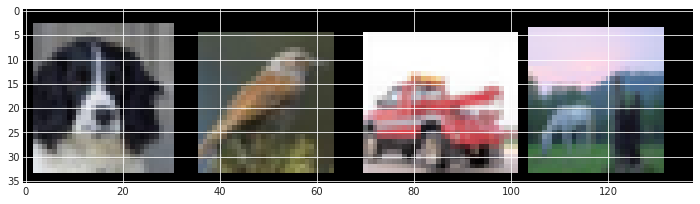

In [308]:
def imshow(img):
    npimg = img.numpy()
    norm_img = (npimg - np.min(npimg))/(np.max(npimg) - np.min(npimg)) # min-max normalization
    fig = plt.figure()
    fig.set_size_inches([12, 6])
    plt.imshow(np.transpose(norm_img, (1, 2, 0)))

# get some random training images
data_iterator = iter(trainloader)
images, labels = data_iterator.next()

imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join('%17s' % classes[labels[j]] for j in range(4))) # print labels
plt.show()

In [310]:
trainloader, testloader, classs, img_shape = get_data(CIFAR10=True, batch_size=64)
img_shape

Files already downloaded and verified
Files already downloaded and verified


(32, 32, 3)

In [285]:
images.shape

torch.Size([4, 1, 32, 32])

### Part (a) - Logistic Regression

**Fully connected output, $0$ hidden layers (logistic regression):** 

We begin with the simplest network possible that has no hidden layers and simply linearly maps the input layer to the output layer. That is, conceptually it could be written as

$$ x^{out} = W\cdot \text{vec}(x^{in}) + b $$

where $x^{out} \in \mathbb{R}^{10}$, $x^{in} \in \mathbb{R}^{32 \times 32 \times 3}$, $W \in \mathbb{R}^{10, 3072}$, $b \in \mathbb{R}^{10}$ where $3072 = 32 \cdot 32 \cdot 3$. For a tensor $x \in \mathbb{R}^{a \times b \times c}$, we let vec$(x) \in \mathbb{R}^{abc}$ be the reshaped from a tensor into a vector (in an arbitrary but consistent pattern).

#### Model for part (a)

Define model architecture

In [286]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(np.prod(img_shape), 10)

    def forward(self, x):
        x = x.view(-1, np.prod(img_shape))
        out = self.linear(x)
        return out

Compile model

In [287]:
#lr_net = LinearRegression().cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr_net = LinearRegression().to(device)

Choose Optimizer

In [288]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lr_net.parameters(), lr=0.001, momentum=0.9)

Designate your performance metric (accuracy in our case)

Train + Evaluate concurrently

In [289]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_accuracy, test_accuracy, loss_list = [], [], []
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs       
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = lr_net(inputs)
        loss = criterion(outputs, labels)
      
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
     
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lr_net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))       
print('Finished Training')

Accuracy of the network on the 10000 test images: 73 %
Finished Training


In [290]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = lr_net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 92 %
Accuracy of     1 : 85 %
Accuracy of     2 : 75 %
Accuracy of     3 : 50 %
Accuracy of     4 : 66 %
Accuracy of     5 : 60 %
Accuracy of     6 : 80 %
Accuracy of     7 : 100 %
Accuracy of     8 : 40 %
Accuracy of     9 : 100 %


In [291]:
def class_accuracies(dataloader, model):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

**The training stage can be abstracted.** Notice (almost) nothing is hardcoded to the specific task.

In [292]:
def evaluate(dataloader, model, device):
    correct, total = 0, 0 
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    return correct/total

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

        
        
def train(model, trainloader, testloader, criterion, optimizer, device, 
          epochs=1, weight_decay=False, print_freq=1):
    
    train_accuracy, test_accuracy, loss_list = [], [], []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # wrap the inputs       
            inputs, labels = inputs.to(device), labels.to(device)
      
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Decay learning rate
        if weight_decay and (epoch+1) % 20 == 0:
            curr_lr /= 3
            update_lr(optimizer, curr_lr)
        
        if epoch % print_freq == 0:
            train_acc = evaluate(trainloader, model, device) 
            train_accuracy.append(train_acc)

            test_acc = evaluate(testloader, model, device)
            test_accuracy.append(test_acc)
            loss_list.append(loss.item())
        
            print('[Epoch %2d ||  Train acc: %d %% | Test acc: %d %% | loss: %.3f ]' 
                              % (epoch, train_acc*100, test_acc*100, 
                                 running_loss/(len(trainloader))))

    print('Finished Training')
    return model, train_accuracy, test_accuracy, loss_list

Train `lr_net` again:

In [293]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr_net = LinearRegression().to(device)

In [294]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lr_net.parameters(), lr=0.001, momentum=0.9)

In [295]:
import time
start = time.time()

lr_net, train_acc, test_acc, losses = train(lr_net, trainloader, testloader,
                                            criterion, optimizer, device, 
                                            epochs=10, print_freq=1)

end = time.time()
print('%.1f seconds' % (end - start))

[Epoch  0 ||  Train acc: 73 % | Test acc: 73 % | loss: 1.993 ]
[Epoch  1 ||  Train acc: 78 % | Test acc: 78 % | loss: 1.429 ]
[Epoch  2 ||  Train acc: 81 % | Test acc: 81 % | loss: 1.141 ]
[Epoch  3 ||  Train acc: 82 % | Test acc: 82 % | loss: 0.978 ]
[Epoch  4 ||  Train acc: 83 % | Test acc: 83 % | loss: 0.873 ]
[Epoch  5 ||  Train acc: 84 % | Test acc: 84 % | loss: 0.800 ]
[Epoch  6 ||  Train acc: 84 % | Test acc: 83 % | loss: 0.745 ]
[Epoch  7 ||  Train acc: 85 % | Test acc: 84 % | loss: 0.703 ]
[Epoch  8 ||  Train acc: 85 % | Test acc: 84 % | loss: 0.669 ]
[Epoch  9 ||  Train acc: 85 % | Test acc: 85 % | loss: 0.641 ]
Finished Training
11.5 seconds


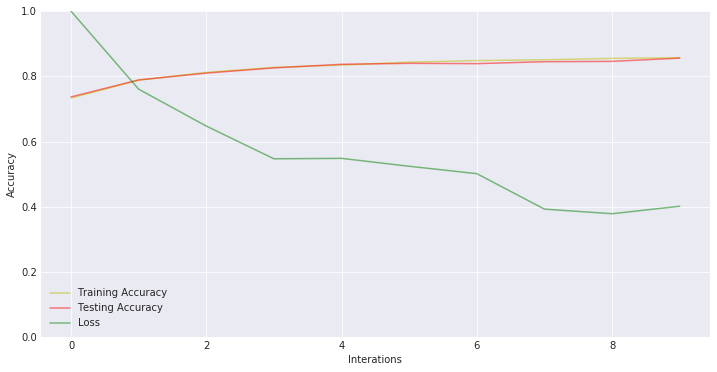

In [296]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='lr_net.png')

In [297]:
class_accuracies(testloader, lr_net)

Accuracy of     0 : 90 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 75 %
Accuracy of     5 : 50 %
Accuracy of     6 : 87 %
Accuracy of     7 : 100 %
Accuracy of     8 : 66 %
Accuracy of     9 : 88 %


### Part (b) - MLP

Fully connected output, 1 fully connected hidden layer: we will have one hidden layer denoted as $x^{hidden} \in \mathbb{R}^M$ where $M$ will be a hyperparameter you choose ($M$ could be in the hundreds). The nonlinearity applied to the hidden layer will be the relu (relu$(x) = \max\{0, x\}$, elementwise). Conceptually, one cold write this network as:

$$ x^{out} = W_2\text{relu}(W_1\text{vec}(x^{in}) + b_1) + b_2$$

where $W_1 \in \mathbb{R}^{M \times 3072}, b_1 \in \mathbb{R}^M, W_2 \in \mathbb{R}^{10 \times M}, b_2 \in \mathbb{R}^{10}$.

In [298]:
# choose the number of hidden layers
M = 128

In [299]:
class OneHidden(nn.Module):
    def __init__(self):
        super(OneHidden, self).__init__()
        self.fc1 = nn.Linear(np.prod(img_shape), M)
        self.fc2 = nn.Linear(M, 10)

    def forward(self, x):
        x = x.view(-1, np.prod(img_shape))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [300]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
one_hidden_net = OneHidden().to(device)

In [301]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(one_hidden_net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [303]:
start = time.time()
one_hidden_net, train_acc, test_acc, losses = train(one_hidden_net, trainloader, testloader,
                                           criterion, optimizer, device=device,
                                           epochs=50, print_freq=1)
end = time.time()
print('%.1f seconds' % (end - start))

[Epoch  0 ||  Train acc: 85 % | Test acc: 85 % | loss: 0.619 ]
[Epoch  1 ||  Train acc: 85 % | Test acc: 86 % | loss: 0.581 ]
[Epoch  2 ||  Train acc: 86 % | Test acc: 86 % | loss: 0.550 ]
[Epoch  3 ||  Train acc: 86 % | Test acc: 87 % | loss: 0.523 ]
[Epoch  4 ||  Train acc: 87 % | Test acc: 87 % | loss: 0.501 ]
[Epoch  5 ||  Train acc: 87 % | Test acc: 87 % | loss: 0.482 ]
[Epoch  6 ||  Train acc: 88 % | Test acc: 87 % | loss: 0.465 ]
[Epoch  7 ||  Train acc: 88 % | Test acc: 88 % | loss: 0.450 ]
[Epoch  8 ||  Train acc: 88 % | Test acc: 88 % | loss: 0.438 ]
[Epoch  9 ||  Train acc: 88 % | Test acc: 88 % | loss: 0.425 ]
[Epoch 10 ||  Train acc: 88 % | Test acc: 88 % | loss: 0.415 ]
[Epoch 11 ||  Train acc: 89 % | Test acc: 88 % | loss: 0.405 ]
[Epoch 12 ||  Train acc: 89 % | Test acc: 88 % | loss: 0.396 ]
[Epoch 13 ||  Train acc: 89 % | Test acc: 88 % | loss: 0.387 ]
[Epoch 14 ||  Train acc: 89 % | Test acc: 88 % | loss: 0.381 ]
[Epoch 15 ||  Train acc: 89 % | Test acc: 88 % | loss: 

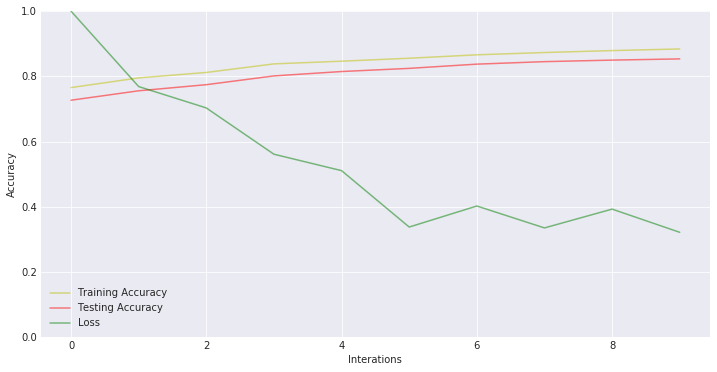

In [247]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='one_hidden_net.png')

In [248]:
class_accuracies(testloader, one_hidden_net)

Accuracy of     0 : 95 %
Accuracy of     1 : 94 %
Accuracy of     2 : 84 %
Accuracy of     3 : 85 %
Accuracy of     4 : 82 %
Accuracy of     5 : 74 %
Accuracy of     6 : 84 %
Accuracy of     7 : 85 %
Accuracy of     8 : 82 %
Accuracy of     9 : 94 %


### Part (c) - Simple Conv Net


Fully connected output, 1 convolutional layer with max-pool: for a convolutional layer $W_1$ with individual filters of size $p \times p \times 3$ and output size $M$ (resonable choices are $M = 100, p = 5$) we have that Conv2d$(x^{input}, W_1) \in \mathbb{R}^{(33 - p)\times (33 - p) \times M}$. 

Each convolution will have its own offset applied to each of the output pixels of the convolution; we denote this as Conv2d$(x^{input}, W) + b_1$ where $b_1$ is parameterized in $\mathbb{R}^M$. We will then apply a relu (relu doesn't change the tensor space) and pool. If we use a max-pool of size $N$ (a resonable choise is $N = 14$ to pool to $2 \times 2$ with $p = 5$) we have that 

$$ \text{MaxPool(relu(Conv2d}(x^{input}, W_1) + b_1)) \in \mathbb{R}^{\lfloor \frac{33-p}{N} \rfloor \times \lfloor \frac{33- p}{N} \rfloor \times M}.$$

We will then apply a fully connected layer to the output to get the final network given as

$$ x^{out} = W_2\text{vec}(\text{MaxPool}(\text{relu}(\text{Conv2d}(x^{in}, W_1) + b_1))) + b_2$$

where $W_2 \in \mathbb{R}^{10 \times M(\lfloor \frac{33-p}{N} \rfloor)^2}, b_2 \in \mathbb{R}^{10}$. The parameters $M, p, N$ (in addition to the step size and the momentum are all hyperparameters.

In [249]:
p = 5 # size of filters
M = 100 # number of filters
N = 14 # pooling size
input_size = img_shape[0]
output_size = 10
channel_nb = img_shape[2] # i.e. RGB
floor_divide = np.floor_divide(input_size + 1 - p, N) # this is floor(28/14) = 2

class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv1 = nn.Conv2d(channel_nb, M, p) ## 6x28x28, where 28 = 33-5
        self.pool = nn.MaxPool2d(N, N) ## 6 x 14 x 14
        self.fc1 = nn.Linear(M * floor_divide * floor_divide, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, M * floor_divide * floor_divide)
        x = self.fc1(x)
        return x

In [250]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
one_conv_net = OneConv().to(device)

In [251]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(one_conv_net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [253]:
start = time.time()
one_conv_net, train_acc, test_acc, losses = train(one_conv_net, trainloader, testloader,
                                           criterion, optimizer, device=device,
                                           epochs=10, print_freq=1)
end = time.time()
print('%.1f seconds' % (end - start))

[Epoch  0 ||  Train acc: 73 % | Test acc: 71 % | loss: 1.964 ]
[Epoch  1 ||  Train acc: 81 % | Test acc: 79 % | loss: 1.793 ]
[Epoch  2 ||  Train acc: 82 % | Test acc: 81 % | loss: 1.606 ]
[Epoch  3 ||  Train acc: 84 % | Test acc: 84 % | loss: 1.419 ]
[Epoch  4 ||  Train acc: 85 % | Test acc: 83 % | loss: 1.243 ]
[Epoch  5 ||  Train acc: 87 % | Test acc: 85 % | loss: 1.087 ]
[Epoch  6 ||  Train acc: 87 % | Test acc: 86 % | loss: 0.956 ]
[Epoch  7 ||  Train acc: 89 % | Test acc: 88 % | loss: 0.843 ]
[Epoch  8 ||  Train acc: 90 % | Test acc: 88 % | loss: 0.751 ]
[Epoch  9 ||  Train acc: 90 % | Test acc: 88 % | loss: 0.676 ]
Finished Training
19.2 seconds


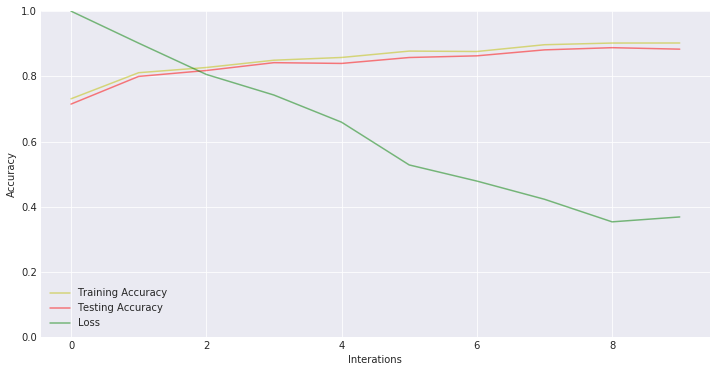

In [254]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='one_conv_net.png')

In [255]:
class_accuracies(testloader, one_conv_net)

Accuracy of     0 : 94 %
Accuracy of     1 : 95 %
Accuracy of     2 : 94 %
Accuracy of     3 : 97 %
Accuracy of     4 : 84 %
Accuracy of     5 : 87 %
Accuracy of     6 : 84 %
Accuracy of     7 : 84 %
Accuracy of     8 : 59 %
Accuracy of     9 : 88 %


### Part (d)

We will return to the original network you were left with at the end of the tutorial Training a classifier, tune the different hyperparameters (number of convolutional filters, filter sizes, dimensionality of the fully connected layers, stepsize, etc.) and train for many epochs to achieve a test accuracy of at least 85%.

##### Model

In [256]:
conv_size1 = 5 
conv_size2 = 3
num_hidden_nodes = 128 ## 
N = 2
input_size = img_shape[0]
output_size = 10
channel_nb = img_shape[2]
pool_size = 2


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input (32, 32, 3)
        self.conv1 = nn.Conv2d(channel_nb, num_hidden_nodes, conv_size1, padding = 2) 
        # input (32, 32, 128)
        self.pool = nn.MaxPool2d(2, 2) 
        # input (16, 16, 128)
        self.conv2 = nn.Conv2d(num_hidden_nodes, 256, 3, padding = 1) 
        # pool
        # input (8, 8, 256)
        self.conv3 = nn.Conv2d(256, 512, 3, padding = 1) 
        # pool
        # input (4, 4, 512)
        self.fc1 = nn.Linear(512 * 4 * 4, 2048) 
        # input (2048)
        self.fc2 = nn.Linear(2048, 256)
        # input (256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 512 * 4 * 4) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [257]:
conv_net = ConvNet().to(device)

In [258]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [259]:
start = time.time() # 22 min on 1080 Ti

conv_net, train_acc, test_acc, losses = train(conv_net, trainloader, testloader,
                                           criterion, optimizer, device=device,
                                           epochs=20, print_freq=1)

end = time.time()
print('%.1f seconds' % (end - start))

[Epoch  0 ||  Train acc: 20 % | Test acc: 20 % | loss: 2.301 ]
[Epoch  1 ||  Train acc: 28 % | Test acc: 27 % | loss: 2.296 ]
[Epoch  2 ||  Train acc: 30 % | Test acc: 29 % | loss: 2.289 ]
[Epoch  3 ||  Train acc: 32 % | Test acc: 32 % | loss: 2.279 ]
[Epoch  4 ||  Train acc: 40 % | Test acc: 41 % | loss: 2.262 ]
[Epoch  5 ||  Train acc: 44 % | Test acc: 44 % | loss: 2.226 ]
[Epoch  6 ||  Train acc: 46 % | Test acc: 48 % | loss: 2.112 ]
[Epoch  7 ||  Train acc: 65 % | Test acc: 64 % | loss: 1.614 ]
[Epoch  8 ||  Train acc: 78 % | Test acc: 74 % | loss: 0.902 ]
[Epoch  9 ||  Train acc: 80 % | Test acc: 77 % | loss: 0.660 ]
[Epoch 10 ||  Train acc: 84 % | Test acc: 82 % | loss: 0.557 ]
[Epoch 11 ||  Train acc: 86 % | Test acc: 83 % | loss: 0.471 ]
[Epoch 12 ||  Train acc: 89 % | Test acc: 86 % | loss: 0.400 ]
[Epoch 13 ||  Train acc: 90 % | Test acc: 88 % | loss: 0.349 ]
[Epoch 14 ||  Train acc: 91 % | Test acc: 88 % | loss: 0.317 ]
[Epoch 15 ||  Train acc: 92 % | Test acc: 89 % | loss: 

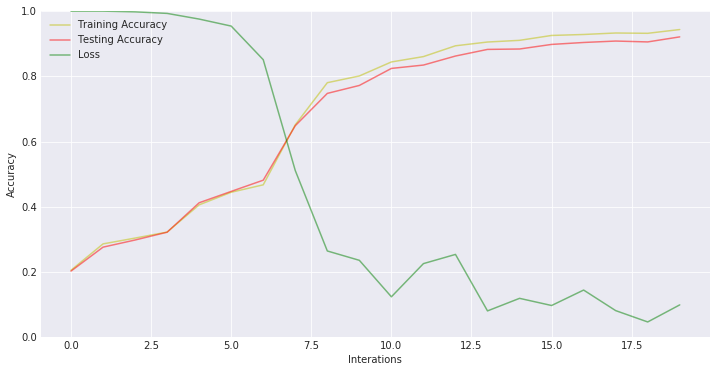

In [260]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='conv_net.png')

##### Accuracy on particular classes

In [261]:
class_accuracies(testloader, conv_net)

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 95 %
Accuracy of     3 : 91 %
Accuracy of     4 : 84 %
Accuracy of     5 : 82 %
Accuracy of     6 : 92 %
Accuracy of     7 : 87 %
Accuracy of     8 : 95 %
Accuracy of     9 : 92 %


In [159]:
test_acc = evaluate(testloader, conv_net, device)
test_acc

0.9521

# ResNet

In [262]:
class ResNetFull(nn.Module):
    def __init__(self):
        super(ResNetFull, self).__init__()
        self.conv1 = nn.Conv2d(img_shape[2],16,kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # layer 1
        # block 1      
        self.conv1_blck1_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn1_blck1_lyr1 = nn.BatchNorm2d(16)
        self.relu_blck1_lyr1 = nn.ReLU(inplace=True)
        self.conv2_blck1_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn2_blck1_lyr1 = nn.BatchNorm2d(16)
        
        # block 2
        self.conv1_blck2_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn1_blck2_lyr1 = nn.BatchNorm2d(16)
        self.relu_blck2_lyr1 = nn.ReLU(inplace=True)
        self.conv2_blck2_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn2_blck2_lyr1 = nn.BatchNorm2d(16)
        
        # block 3
        self.conv1_blck3_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn1_blck3_lyr1 = nn.BatchNorm2d(16)
        self.relu_blck3_lyr1 = nn.ReLU(inplace=True)
        self.conv2_blck3_lyr1 = nn.Conv2d(16,16,kernel_size=3, padding=1, bias=False)
        self.bn2_blck3_lyr1 = nn.BatchNorm2d(16)
        
        # layer 2
        self.downsample1 = nn.Sequential(nn.Conv2d(16, 32, stride=2, kernel_size=3, 
                                        padding=1, bias=False), nn.BatchNorm2d(32))
        
        self.conv1_blck1_lyr2 = nn.Conv2d(32,32,kernel_size=3, padding=1, bias=False)
        self.bn1_blck1_lyr2 = nn.BatchNorm2d(32)
        self.relu_blck1_lyr2 = nn.ReLU(inplace=True)
        self.conv2_blck1_lyr2 = nn.Conv2d(32,32,kernel_size=3, padding=1, bias=False)
        self.bn2_blck1_lyr2 = nn.BatchNorm2d(32)
        
        self.conv1_blck2_lyr2 = nn.Conv2d(32,32,kernel_size=3, padding=1, bias=False)
        self.bn1_blck2_lyr2 = nn.BatchNorm2d(32)
        self.relu_blck2_lyr2 = nn.ReLU(inplace=True)
        self.conv2_blck2_lyr2 = nn.Conv2d(32,32,kernel_size=3, padding=1, bias=False)
        self.bn2_blck2_lyr2 = nn.BatchNorm2d(32)
        
        # layer 3
        self.downsample2 = nn.Sequential(nn.Conv2d(32, 64, stride=2, kernel_size=3, 
                                        padding=1, bias=False),nn.BatchNorm2d(64))
        self.conv1_blck1_lyr3 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bn1_blck1_lyr3 = nn.BatchNorm2d(64)
        self.relu_blck1_lyr3 = nn.ReLU(inplace=True)
        self.conv2_blck1_lyr3 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bn2_blck1_lyr3 =nn.BatchNorm2d(64)
        
        self.conv1_blck2_lyr3 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bn1_blck2_lyr3 = nn.BatchNorm2d(64)
        self.relu_blck2_lyr3 = nn.ReLU(inplace=True)
        self.conv2_blck2_lyr3 = nn.Conv2d(64,64,kernel_size=3, padding=1, bias=False)
        self.bn2_blck2_lyr3 = nn.BatchNorm2d(64)
        
        self.avg_pool = nn.AvgPool2d(8) 
        self.fc1 = nn.Linear(64 * 1 * 1, 10)
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        
        ## layer 1
        # block 1
        residual = out
        out = self.conv1_blck1_lyr1(out)
        out = self.bn1_blck1_lyr1(out)
        out = self.relu_blck1_lyr1(out)
        out = self.conv2_blck1_lyr1(out)
        out = self.bn2_blck1_lyr1(out)
        out += residual
        
        # block 2
        residual = out
        out = self.conv1_blck2_lyr1(out)
        out = self.bn1_blck2_lyr1(out)
        out = self.relu_blck2_lyr1(out)
        out = self.conv2_blck2_lyr1(out)
        out = self.bn2_blck2_lyr1(out)
        out += residual
        
        # block 3
        residual = out
        out = self.conv1_blck3_lyr1(out)
        out = self.bn1_blck3_lyr1(out)
        out = self.relu_blck3_lyr1(out)
        out = self.conv2_blck3_lyr1(out)
        out = self.bn2_blck3_lyr1(out)
        out += residual
        

        ## layer 2
        # block 1
        residual = self.downsample1(out)
        out = self.downsample1(out) # downsample
        out = self.conv1_blck1_lyr2(out)
        out = self.bn1_blck1_lyr2(out)
        out = self.relu_blck1_lyr2(out)
        out = self.conv2_blck1_lyr2(out)
        out = self.bn2_blck1_lyr2(out)
        out += residual
        
        # block 2
        residual = out
        out = self.conv1_blck2_lyr2(out)
        out = self.bn1_blck2_lyr2(out)
        out = self.relu_blck2_lyr2(out)
        out = self.conv2_blck2_lyr2(out)
        out = self.bn2_blck2_lyr2(out)
        out += residual


        ## layer 3
        # block 1
        residual = self.downsample2(out)
        out = self.downsample2(out) # downsample
        out = self.conv1_blck1_lyr3(out)
        out = self.bn1_blck1_lyr3(out)
        out = self.relu_blck1_lyr3(out)
        out = self.conv2_blck1_lyr3(out)
        out = self.bn2_blck1_lyr3(out)
        out += residual
        
        # block 2
        residual = out
        out = self.conv1_blck2_lyr3(out)
        out = self.bn1_blck2_lyr3(out)
        out = self.relu_blck2_lyr3(out)
        out = self.conv2_blck2_lyr3(out)
        out = self.bn2_blck2_lyr3(out)
        out += residual
        
        out = self.avg_pool(out)
        out = out.view(-1, 1*1*64)
        out = self.fc1(out)
        return out

In [263]:
fullnet = ResNetFull().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fullnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(fullnet.parameters(), betas = (0.9, 0.999))

In [264]:
start = time.time() 

fullnet, train_acc, test_acc, losses = train(fullnet, trainloader, testloader,
                                           criterion, optimizer, device=device,
                                           epochs=100, print_freq=1)

end = time.time()
print('%.1f seconds' % (end - start))

[Epoch  0 ||  Train acc: 40 % | Test acc: 37 % | loss: 2.072 ]
[Epoch  1 ||  Train acc: 72 % | Test acc: 69 % | loss: 1.428 ]
[Epoch  2 ||  Train acc: 90 % | Test acc: 88 % | loss: 0.818 ]
[Epoch  3 ||  Train acc: 93 % | Test acc: 92 % | loss: 0.451 ]
[Epoch  4 ||  Train acc: 95 % | Test acc: 94 % | loss: 0.300 ]
[Epoch  5 ||  Train acc: 95 % | Test acc: 94 % | loss: 0.231 ]
[Epoch  6 ||  Train acc: 96 % | Test acc: 95 % | loss: 0.188 ]
[Epoch  7 ||  Train acc: 97 % | Test acc: 96 % | loss: 0.155 ]
[Epoch  8 ||  Train acc: 97 % | Test acc: 96 % | loss: 0.134 ]
[Epoch  9 ||  Train acc: 97 % | Test acc: 96 % | loss: 0.123 ]
[Epoch 10 ||  Train acc: 97 % | Test acc: 96 % | loss: 0.111 ]
[Epoch 11 ||  Train acc: 98 % | Test acc: 96 % | loss: 0.097 ]
[Epoch 12 ||  Train acc: 98 % | Test acc: 96 % | loss: 0.093 ]
[Epoch 13 ||  Train acc: 98 % | Test acc: 97 % | loss: 0.085 ]
[Epoch 14 ||  Train acc: 98 % | Test acc: 97 % | loss: 0.075 ]
[Epoch 15 ||  Train acc: 98 % | Test acc: 97 % | loss: 

KeyboardInterrupt: 

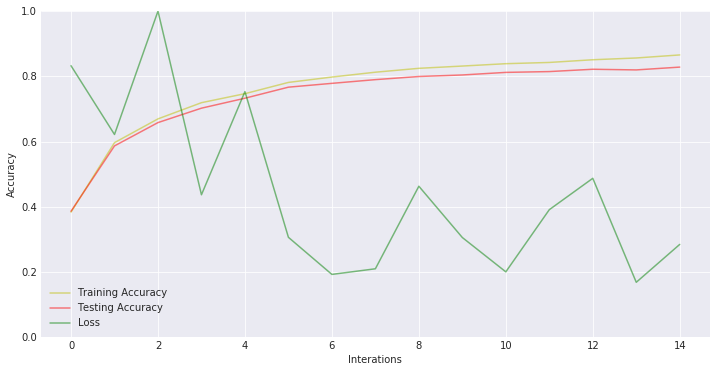

In [185]:
plot_acc(train_acc, test_acc, losses)
#plot_acc(train_acc, test_acc, losses, save=True, outfile='res_net.png')

In [ ]:
class_accuracies(testloader, fullnet)

## ResNet, cleaner

In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(img_shape[2], 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
resnet = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), betas = (0.9, 0.999))

In [ ]:
resnet, train_acc, test_acc, losses = train(resnet, trainloader, testloader,
                                           criterion, optimizer, epochs=120, weight_decay=True)

In [ ]:
plot_acc(train_acc, test_acc, losses)